## Project 3 - City Segmentation - Train
This is training source with UNET and dice loss. With epoch = 100 still cannot produce good result

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nproc

8


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
mask_path = f"datasets_used/train/masks/0016E5_06330.png"
m = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
#6  8  9 11]
replace_val = {6: 5, 8: 6, 9: 7, 11: 8}
for key, val in replace_val.items():
    m[m == key] = val

In [ ]:
np.unique(m)
cv2.imwrite('tes.png', m)

True

In [ ]:
n= cv2.imread('tes.png',cv2.IMREAD_GRAYSCALE)

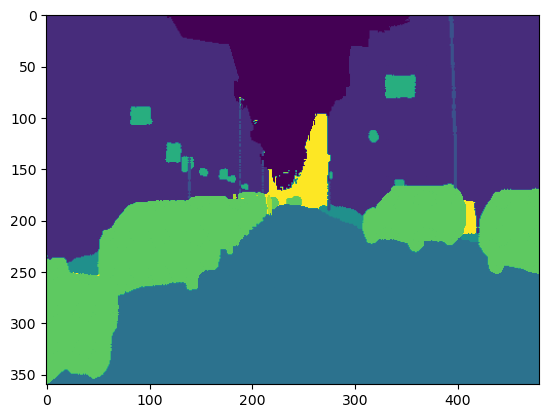

In [ ]:
plt.imshow(n)

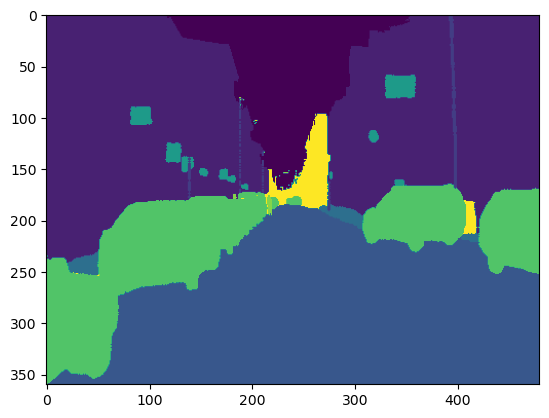

In [ ]:
mask_path = f"datasets_used/train/masks/0016E5_06330.png"
m = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
plt.imshow(m)

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import numpy as np
import os

class CityscapesDataset(Dataset):

    def __init__(self, root, split=None, from_start=True, transform=None, eval=False ):
        super().__init__()
        self.root = root
        self.split = split
        self.transform = transform
        self.eval = eval
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root,"masks"))))
        #self.split_imgs = []
        #self.split_masks = []

        if split is None :
          pass
        elif from_start is True :
          self.imgs = self.imgs[:int(len(self.imgs)*split)]
          self.masks = self.masks[:int(len(self.masks)*split)]
        elif from_start is False :
          self.imgs = self.imgs[int(len(self.imgs)*split):]
          self.masks = self.masks[int(len(self.masks)*split):]

        print(len(self.masks))
        print(self.imgs[0:2])

    def __len__(self):
        length = len(self.imgs)
        return length


    def __getitem__(self, idx):
        file_img = os.path.join(f"{self.root}/images",self.imgs[idx])
        file_mask = os.path.join(f"{self.root}/masks",self.masks[idx])

        image = Image.open(file_img)
        masks = Image.open(file_mask)

        if self.transform is not None:
            image = self.transform(image)
            masks = self.transform(masks)

        image = transforms.ToTensor()(image)
        masks = np.array(masks)
        masks = torch.from_numpy(masks)

        #masks = masks/255
        masks.dtype
        #masks = masks.type(torch.LongTensor)
        masks = masks.type(torch.LongTensor)
        if self.eval:
            return image, masks, self.imgs[idx]
        else:
            return image, masks




In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class UNET(nn.Module):

    def __init__(self, in_channels=3, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []

        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, utils, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

#root, split=None, from_start=True, transform=None, eval=False ):

def get_cityscapes_data(
    split,
    from_start=True,
    root_dir=f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used",  #'datasets_used',
    transforms=None,
    batch_size=8,
    eval=False,
    shuffle=True,
    pin_memory=True,

):
    data = CityscapesDataset(
        root=root_dir, split=split, from_start=from_start, transform=transforms, eval=eval)

    data_loaded = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

    return data_loaded

# Functions to save predictions as images
def save_as_images(tensor_pred, folder, image_name):
    tensor_pred = transforms.ToPILImage()(tensor_pred.byte())
    filename = f"{folder}\{image_name}.png"
    tensor_pred.save(filename)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply sigmoid or softmax to logits if necessary
        logits = torch.softmax(logits, dim=1)

        # Convert targets to one-hot encoding
        num_classes = logits.shape[1]
        targets = nn.functional.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

        # Calculate Dice coefficient
        intersection = (logits * targets).sum(dim=(2, 3))
        union = logits.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice = dice.mean(dim=1)  # Average across classes

        return 1 - dice.mean()  # Dice loss is 1 - Dice coefficient

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
import shutil
#from utils import *
#from model import UNET

if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')

MODEL_PATH = f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/ckpt_save/unet-dice.pth" #'ckpt_save/unet'
BEST_MODEL_PATH = f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/ckpt_save/best-unet-dice.pth"
LOAD_MODEL = False
ROOT_DIR = f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used" #'datasets_used'
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
LEARNING_RATE = 0.0002 #0.0001 #0.0005
EPOCHS = 80

def train_function(data, model, optimizer, loss_fn, device):
    print('Entering into train function')
    loss_values = []
    data = tqdm(data)
    for index, batch in enumerate(data):
        X, y = batch
        X, y = X.to(device), y.to(device)
        preds = model(X)
        #pred_labels = torch.argmax(preds, dim=1)
        #print(f"preds shape {preds.shape} with {preds.dtype} {pred_labels.shape}")
        #print(f"y shape {y.shape} with {y.dtype}")
        #print(pred_labels)
        #print(y)

        loss = loss_fn(preds, y)
        #loss = loss_fn(pred_labels, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

def val_function(data, model, loss_fn, device):
    model.eval()
    print('Entering into validation function')
    loss_values = []
    data = tqdm(data)
    for index, batch in enumerate(data):
        with torch.no_grad():
            X, y = batch
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)

    return loss.item()

def program_main():
    global epoch
    epoch = 0 # epoch is initially assigned to 0. If LOAD_MODEL is true then
              # epoch is set to the last value + 1.
    LOSS_TRAIN = [] # Defining a list to store loss values after every epoch
    LOSS_VAL = []

    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
    ])


    train_set = get_cityscapes_data(
        split=0.8,
        from_start=True,
        root_dir=f"{ROOT_DIR}/train",
        transforms=transform,
        batch_size=BATCH_SIZE,
    )
    val_set = get_cityscapes_data(
        split=0.8,
        from_start=False,
        root_dir=f"{ROOT_DIR}/train",
        transforms=transform,
        batch_size=BATCH_SIZE,
    )


    print('Data Loaded Successfully!')

    # Defining the model, optimizer and loss function
    unet = UNET(in_channels=3, classes=12).to(DEVICE).train()
    optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    #loss_function = nn.CrossEntropyLoss(ignore_index=255)
    loss_function = DiceLoss()


    # Loading a previous stored model from MODEL_PATH variable
    if LOAD_MODEL == True:
        checkpoint = torch.load(MODEL_PATH)
        unet.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        epoch = checkpoint['epoch']+1
        LOSS_TRAIN = checkpoint['loss_train']
        LOSS_VAL = checkpoint['loss_validation']
        print("Model successfully loaded!")

    best_loss_val = 0 #dice loss best performance near 1
    #Training the model for every epoch.
    for e in range(epoch, EPOCHS):
        print(f'Epoch: {e}')
        loss_train = train_function(train_set, unet, optimizer, loss_function, DEVICE)
        print(f"Loss Train : {loss_train}")
        LOSS_TRAIN.append(loss_train)
        loss_val = val_function(val_set, unet, loss_function, DEVICE)
        LOSS_VAL.append(loss_val)
        print(f"Loss Validation : {loss_val}")

        torch.save({
            'model_state_dict': unet.state_dict(),
            'optim_state_dict': optimizer.state_dict(),
            'epoch': e,
            'loss_train': LOSS_TRAIN,
            'loss_validation': LOSS_VAL
        }, MODEL_PATH)

        if loss_val > best_loss_val :
            best_loss_val = loss_val
            shutil.copyfile(MODEL_PATH, BEST_MODEL_PATH)

        print("Epoch completed and model successfully saved!")

Running on the GPU


In [ ]:
program_main()

293
['0001TP_006690.png', '0001TP_006720.png']
74
['0016E5_06210.png', '0016E5_06240.png']
Data Loaded Successfully!
Epoch: 0
Entering into train function


100%|██████████| 37/37 [03:59<00:00,  6.48s/it]


Loss Train : 0.7686190605163574
Entering into validation function


100%|██████████| 10/10 [01:03<00:00,  6.35s/it]


Loss Validation : 0.8654597997665405
Epoch completed and model successfully saved!
Epoch: 1
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.7661862373352051
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


Loss Validation : 0.7686727046966553
Epoch completed and model successfully saved!
Epoch: 2
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.46it/s]


Loss Train : 0.5726131200790405
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


Loss Validation : 0.6722644567489624
Epoch completed and model successfully saved!
Epoch: 3
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.49it/s]


Loss Train : 0.6423571109771729
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


Loss Validation : 0.5720123052597046
Epoch completed and model successfully saved!
Epoch: 4
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.5394549369812012
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


Loss Validation : 0.6242738962173462
Epoch completed and model successfully saved!
Epoch: 5
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.592218279838562
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Loss Validation : 0.5494968891143799
Epoch completed and model successfully saved!
Epoch: 6
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.47it/s]


Loss Train : 0.5362614989280701
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


Loss Validation : 0.5469893217086792
Epoch completed and model successfully saved!
Epoch: 7
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.5084463357925415
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.89it/s]


Loss Validation : 0.5677787065505981
Epoch completed and model successfully saved!
Epoch: 8
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.47608232498168945
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.632929801940918
Epoch completed and model successfully saved!
Epoch: 9
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.49915987253189087
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.7063164710998535
Epoch completed and model successfully saved!
Epoch: 10
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.748680830001831
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.8249126672744751
Epoch completed and model successfully saved!
Epoch: 11
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.46it/s]


Loss Train : 0.8387904167175293
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Loss Validation : 0.7876533269882202
Epoch completed and model successfully saved!
Epoch: 12
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.51it/s]


Loss Train : 0.8300690650939941
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.89it/s]


Loss Validation : 0.8345005512237549
Epoch completed and model successfully saved!
Epoch: 13
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Loss Train : 0.830103874206543
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


Loss Validation : 0.8692158460617065
Epoch completed and model successfully saved!
Epoch: 14
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.8653282523155212
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.9125307202339172
Epoch completed and model successfully saved!
Epoch: 15
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.50it/s]


Loss Train : 0.8573492765426636
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Loss Validation : 0.9212944507598877
Epoch completed and model successfully saved!
Epoch: 16
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.8259106874465942
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.784576416015625
Epoch completed and model successfully saved!
Epoch: 17
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.8094531297683716
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.8308815956115723
Epoch completed and model successfully saved!
Epoch: 18
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.51it/s]


Loss Train : 0.8938233256340027
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


Loss Validation : 0.7890961170196533
Epoch completed and model successfully saved!
Epoch: 19
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.8355567455291748
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


Loss Validation : 0.8302477598190308
Epoch completed and model successfully saved!
Epoch: 20
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.50it/s]


Loss Train : 0.8416969180107117
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Loss Validation : 0.7850812077522278
Epoch completed and model successfully saved!
Epoch: 21
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.47it/s]


Loss Train : 0.8308582901954651
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Loss Validation : 0.8776921629905701
Epoch completed and model successfully saved!
Epoch: 22
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.52it/s]


Loss Train : 0.8407087922096252
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.8842969536781311
Epoch completed and model successfully saved!
Epoch: 23
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Loss Train : 0.9591788053512573
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.872556209564209
Epoch completed and model successfully saved!
Epoch: 24
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.846441388130188
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Loss Validation : 0.8697732090950012
Epoch completed and model successfully saved!
Epoch: 25
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.45it/s]


Loss Train : 0.8903010487556458
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.8712618947029114
Epoch completed and model successfully saved!
Epoch: 26
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.52it/s]


Loss Train : 0.9418210983276367
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.9281750917434692
Epoch completed and model successfully saved!
Epoch: 27
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.8873701095581055
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.9490717649459839
Epoch completed and model successfully saved!
Epoch: 28
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.46it/s]


Loss Train : 0.8633626103401184
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Loss Validation : 0.9507883787155151
Epoch completed and model successfully saved!
Epoch: 29
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.879730224609375
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.8738324046134949
Epoch completed and model successfully saved!
Epoch: 30
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.44it/s]


Loss Train : 0.8119744062423706
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.9517539739608765
Epoch completed and model successfully saved!
Epoch: 31
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.938727855682373
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.792983889579773
Epoch completed and model successfully saved!
Epoch: 32
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.8600649833679199
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.7449471354484558
Epoch completed and model successfully saved!
Epoch: 33
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.8701703548431396
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.7473766803741455
Epoch completed and model successfully saved!
Epoch: 34
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.854962944984436
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.9526686072349548
Epoch completed and model successfully saved!
Epoch: 35
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.8518414497375488
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.7934475541114807
Epoch completed and model successfully saved!
Epoch: 36
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.8637372255325317
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.9557357430458069
Epoch completed and model successfully saved!
Epoch: 37
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.8710855841636658
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.883989691734314
Epoch completed and model successfully saved!
Epoch: 38
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.8360797762870789
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Loss Validation : 0.917453408241272
Epoch completed and model successfully saved!
Epoch: 39
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.45it/s]


Loss Train : 0.88301020860672
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.9526121616363525
Epoch completed and model successfully saved!
Epoch: 40
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.8862519264221191
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Loss Validation : 0.8738921880722046
Epoch completed and model successfully saved!
Epoch: 41
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.47it/s]


Loss Train : 0.8185083866119385
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Loss Validation : 0.9547521471977234
Epoch completed and model successfully saved!
Epoch: 42
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.43it/s]


Loss Train : 0.8161237239837646
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Loss Validation : 0.8244132399559021
Epoch completed and model successfully saved!
Epoch: 43
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.8453230261802673
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Loss Validation : 0.8783373236656189
Epoch completed and model successfully saved!
Epoch: 44
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.8263973593711853
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.8343496322631836
Epoch completed and model successfully saved!
Epoch: 45
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.7610188722610474
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.9580167531967163
Epoch completed and model successfully saved!
Epoch: 46
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.7963091135025024
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.8714345693588257
Epoch completed and model successfully saved!
Epoch: 47
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.8666861057281494
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Loss Validation : 0.7490050196647644
Epoch completed and model successfully saved!
Epoch: 48
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.881449282169342
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Loss Validation : 0.7014497518539429
Epoch completed and model successfully saved!
Epoch: 49
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.49it/s]


Loss Train : 0.8565009832382202
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Loss Validation : 0.9597135782241821
Epoch completed and model successfully saved!
Epoch: 50
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.8581171035766602
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


Loss Validation : 0.8814671635627747
Epoch completed and model successfully saved!
Epoch: 51
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.7895829081535339
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.8399114608764648
Epoch completed and model successfully saved!
Epoch: 52
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.8821673393249512
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.8283819556236267
Epoch completed and model successfully saved!
Epoch: 53
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.43it/s]


Loss Train : 0.7459791898727417
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Loss Validation : 0.8424121141433716
Epoch completed and model successfully saved!
Epoch: 54
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.44it/s]


Loss Train : 0.8302409052848816
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Loss Validation : 0.9590120315551758
Epoch completed and model successfully saved!
Epoch: 55
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.8697853088378906
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Loss Validation : 0.832377552986145
Epoch completed and model successfully saved!
Epoch: 56
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.7861040234565735
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.8710691928863525
Epoch completed and model successfully saved!
Epoch: 57
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.9329921007156372
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.8337451219558716
Epoch completed and model successfully saved!
Epoch: 58
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.8424792289733887
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.8400310277938843
Epoch completed and model successfully saved!
Epoch: 59
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.870681881904602
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.9197661876678467
Epoch completed and model successfully saved!
Epoch: 60
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.48it/s]


Loss Train : 0.7877331972122192
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.9227641820907593
Epoch completed and model successfully saved!
Epoch: 61
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.48it/s]


Loss Train : 0.8178166747093201
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Loss Validation : 0.9186038970947266
Epoch completed and model successfully saved!
Epoch: 62
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.7625412940979004
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.9689167737960815
Epoch completed and model successfully saved!
Epoch: 63
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.8364665508270264
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.8296875357627869
Epoch completed and model successfully saved!
Epoch: 64
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.8044263124465942
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Loss Validation : 0.9555517435073853
Epoch completed and model successfully saved!
Epoch: 65
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.8828702569007874
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.7966777682304382
Epoch completed and model successfully saved!
Epoch: 66
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.48it/s]


Loss Train : 0.9062820672988892
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Loss Validation : 0.8293861150741577
Epoch completed and model successfully saved!
Epoch: 67
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.885638952255249
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.8331055045127869
Epoch completed and model successfully saved!
Epoch: 68
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.6716043949127197
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.956915020942688
Epoch completed and model successfully saved!
Epoch: 69
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Loss Train : 0.8614908456802368
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.8675714731216431
Epoch completed and model successfully saved!
Epoch: 70
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.45it/s]


Loss Train : 0.8323853015899658
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Loss Validation : 0.8714728355407715
Epoch completed and model successfully saved!
Epoch: 71
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.8479021191596985
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.873282790184021
Epoch completed and model successfully saved!
Epoch: 72
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.8152765035629272
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


Loss Validation : 0.875212550163269
Epoch completed and model successfully saved!
Epoch: 73
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.8213762640953064
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.874973475933075
Epoch completed and model successfully saved!
Epoch: 74
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.8321205973625183
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Loss Validation : 0.9271132349967957
Epoch completed and model successfully saved!
Epoch: 75
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.8309374451637268
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.8251824975013733
Epoch completed and model successfully saved!
Epoch: 76
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.8620498776435852
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


Loss Validation : 0.8742613792419434
Epoch completed and model successfully saved!
Epoch: 77
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.8858739733695984
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.9565048217773438
Epoch completed and model successfully saved!
Epoch: 78
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.7424301505088806
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


Loss Validation : 0.8749885559082031
Epoch completed and model successfully saved!
Epoch: 79
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.7939754128456116
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


Loss Validation : 0.7448915243148804
Epoch completed and model successfully saved!


In [ ]:
def program_main(EPOCHS, MODEL_PATH, ROOT_DIR, LOAD_MODEL=False ):
    #global epoch
    epoch = 0 # epoch is initially assigned to 0. If LOAD_MODEL is true then
              # epoch is set to the last value + 1.
    LOSS_TRAIN = [] # Defining a list to store loss values after every epoch
    LOSS_VAL = []

    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
    ])


    train_set = get_cityscapes_data(
        split=0.8,
        from_start=True,
        root_dir=f"{ROOT_DIR}/train",
        transforms=transform,
        batch_size=BATCH_SIZE,
    )
    val_set = get_cityscapes_data(
        split=0.8,
        from_start=False,
        root_dir=f"{ROOT_DIR}/train",
        transforms=transform,
        batch_size=BATCH_SIZE,
    )


    print('Data Loaded Successfully!')

    # Defining the model, optimizer and loss function
    unet = UNET(in_channels=3, classes=12).to(DEVICE).train()
    optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    loss_function = nn.CrossEntropyLoss(ignore_index=255)

    # Loading a previous stored model from MODEL_PATH variable
    if LOAD_MODEL == True:
        checkpoint = torch.load(MODEL_PATH)
        unet.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        epoch = checkpoint['epoch']+1
        LOSS_TRAIN = checkpoint['loss_train']
        LOSS_VAL = checkpoint['loss_validation']
        print("Model successfully loaded!")

    #Training the model for every epoch.
    for e in range(epoch, EPOCHS):
        print(f'Epoch: {e}')
        loss_train = train_function(train_set, unet, optimizer, loss_function, DEVICE)
        print(f"Loss Train : {loss_train}")
        LOSS_TRAIN.append(loss_train)
        loss_val = val_function(val_set, unet, loss_function, DEVICE)
        LOSS_VAL.append(loss_val)
        print(f"Loss Validation : {loss_val}")

        torch.save({
            'model_state_dict': unet.state_dict(),
            'optim_state_dict': optimizer.state_dict(),
            'epoch': e,
            'loss_train': LOSS_TRAIN,
            'loss_validation': LOSS_VAL
        }, MODEL_PATH)
        print("Epoch completed and model successfully saved!")

In [ ]:
#train again
EPOCHS = 80
MODEL_PATH = f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/ckpt_save/unet.pth" #'ckpt_save/unet'
LOAD_MODEL = True
ROOT_DIR = f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used" #'datasets_used'
program_main(EPOCHS, MODEL_PATH, ROOT_DIR, LOAD_MODEL=True )

293
['0001TP_006690.png', '0001TP_006720.png']
74
['0016E5_06210.png', '0016E5_06240.png']
Data Loaded Successfully!
Model successfully loaded!
Epoch: 50
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.4422876834869385
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.7826354503631592
Epoch completed and model successfully saved!
Epoch: 51
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.4605441987514496
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Loss Validation : 0.5607150197029114
Epoch completed and model successfully saved!
Epoch: 52
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.44888558983802795
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.7050578594207764
Epoch completed and model successfully saved!
Epoch: 53
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


Loss Train : 0.3900877833366394
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.6594775915145874
Epoch completed and model successfully saved!
Epoch: 54
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.34324970841407776
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.6209506988525391
Epoch completed and model successfully saved!
Epoch: 55
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.27121058106422424
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.3675194978713989
Epoch completed and model successfully saved!
Epoch: 56
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.3274766504764557
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.7487174272537231
Epoch completed and model successfully saved!
Epoch: 57
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.2348337471485138
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.7233593463897705
Epoch completed and model successfully saved!
Epoch: 58
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.2228289544582367
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Loss Validation : 0.5689392685890198
Epoch completed and model successfully saved!
Epoch: 59
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.33467021584510803
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.940548837184906
Epoch completed and model successfully saved!
Epoch: 60
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.25245222449302673
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.5786527395248413
Epoch completed and model successfully saved!
Epoch: 61
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.34954145550727844
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Loss Validation : 0.44795912504196167
Epoch completed and model successfully saved!
Epoch: 62
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.20346207916736603
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 1.4910354614257812
Epoch completed and model successfully saved!
Epoch: 63
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.17832525074481964
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.6748890280723572
Epoch completed and model successfully saved!
Epoch: 64
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.25599223375320435
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.899010419845581
Epoch completed and model successfully saved!
Epoch: 65
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.21157479286193848
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.5981136560440063
Epoch completed and model successfully saved!
Epoch: 66
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.2130696326494217
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.6460167765617371
Epoch completed and model successfully saved!
Epoch: 67
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.15353111922740936
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Loss Validation : 0.2767326235771179
Epoch completed and model successfully saved!
Epoch: 68
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.1537519246339798
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.2730003595352173
Epoch completed and model successfully saved!
Epoch: 69
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.18080255389213562
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.6577478647232056
Epoch completed and model successfully saved!
Epoch: 70
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.1654084026813507
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.7684720754623413
Epoch completed and model successfully saved!
Epoch: 71
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.23560377955436707
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.7869185209274292
Epoch completed and model successfully saved!
Epoch: 72
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.1819673478603363
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.5472335815429688
Epoch completed and model successfully saved!
Epoch: 73
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.18656793236732483
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 1.4065223932266235
Epoch completed and model successfully saved!
Epoch: 74
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.13791492581367493
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.9048665761947632
Epoch completed and model successfully saved!
Epoch: 75
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.1521412432193756
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.5423398613929749
Epoch completed and model successfully saved!
Epoch: 76
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.19340603053569794
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.47969335317611694
Epoch completed and model successfully saved!
Epoch: 77
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.17051509022712708
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.38846325874328613
Epoch completed and model successfully saved!
Epoch: 78
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.17142269015312195
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Loss Validation : 0.9358745217323303
Epoch completed and model successfully saved!
Epoch: 79
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.17721691727638245
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.580828070640564
Epoch completed and model successfully saved!


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(path):
    checkpoint = torch.load(path)
    loss_train = checkpoint['loss_train']
    loss_validation = checkpoint['loss_validation']
    epoch = checkpoint['epoch']
    epoch_list = list(range(epoch+1))
    print(epoch_list)

    plt.plot(epoch_list, loss_train, 'b', label='train')
    plt.plot(epoch_list, loss_validation, 'g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Loss over {epoch+1} epoch/s")
    plt.legend()
    plt.show()

#plot_losses(MODEL_PATH)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


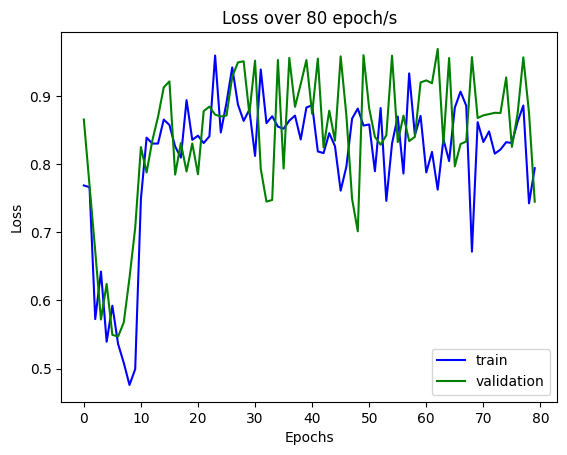

In [ ]:
plot_losses(MODEL_PATH)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


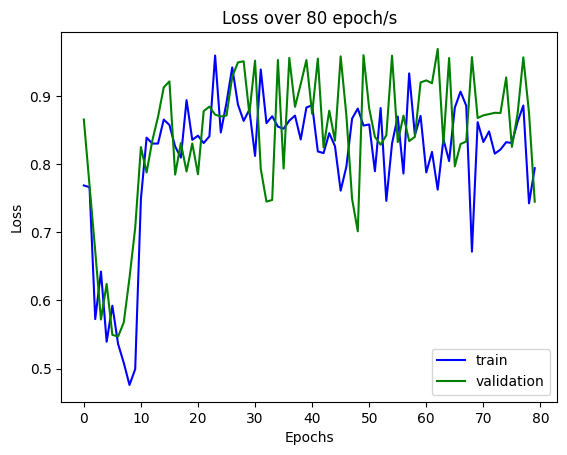

In [ ]:
plot_losses(MODEL_PATH)

In [ ]:
from PIL import Image
from torchvision import transforms
IMG_HEIGHT = 256
IMG_WIDTH = 256

def predict_single_image(img_path) :
    if torch.cuda.is_available():
        DEVICE = 'cuda:0'
        print('Running on the GPU')
    else:
        DEVICE = "cpu"
        print('Running on the CPU')
        print(DEVICE)

    transform = transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
        ])

    image = Image.open(img_path)
    image = transforms.ToTensor()(image)
    image = image.unsqueeze(0)
    image = image.to(DEVICE)

    model = UNET(in_channels=3, classes=12).to(DEVICE).train()
    checkpoint = torch.load(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/ckpt_save/unet-dice.pth") #  'ckpt_save/unet')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    with torch.no_grad():
        output = model(image)
        output = torch.softmax(output, dim=1)
        pred = torch.argmax(output, dim=1)

    pred = pred.squeeze().cpu().numpy()


    # Visualize the result
    plt.imshow(pred)
    plt.show()

In [ ]:
predict_single_image(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used/train/images/0016E5_06330.png")

Running on the GPU


NameError: name 'plt' is not defined

Running on the GPU


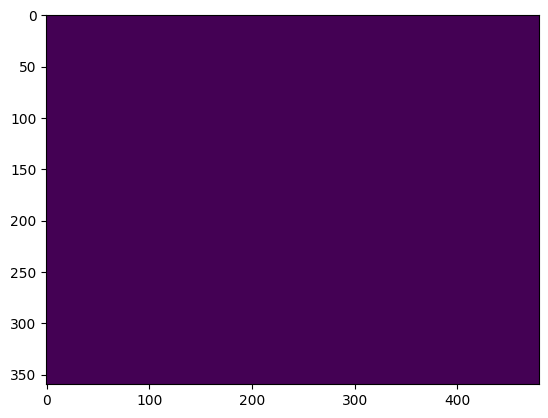

In [ ]:
predict_single_image(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used/train/images/0016E5_06330.png")

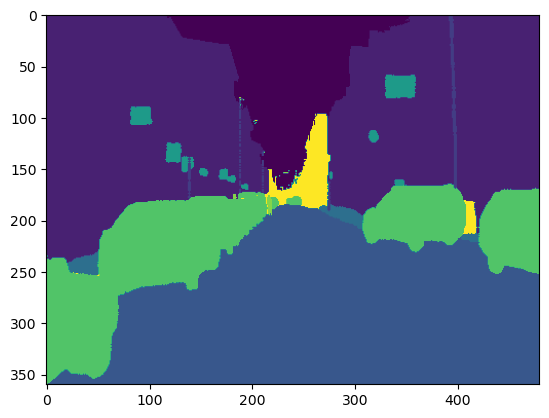

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
n= cv2.imread(f"datasets_used/train/masks/0016E5_06330.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(n)

In [ ]:
#LR 0.0001 epoch 20
program_main()

293
['0001TP_006690.png', '0001TP_006720.png']
74
['0016E5_06210.png', '0016E5_06240.png']
Data Loaded Successfully!
Epoch: 0
Entering into train function


100%|██████████| 37/37 [02:54<00:00,  4.72s/it]


Loss Train : 0.8404789566993713
Entering into validation function


100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Loss Validation : 0.8828452229499817
Epoch completed and model successfully saved!
Epoch: 1
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.50it/s]


Loss Train : 0.7502403259277344
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


Loss Validation : 0.7593469619750977
Epoch completed and model successfully saved!
Epoch: 2
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.5788112878799438
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


Loss Validation : 0.6781966090202332
Epoch completed and model successfully saved!
Epoch: 3
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.45it/s]


Loss Train : 0.6546133756637573
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


Loss Validation : 0.7130706310272217
Epoch completed and model successfully saved!
Epoch: 4
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.49it/s]


Loss Train : 0.552009105682373
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


Loss Validation : 0.6163030862808228
Epoch completed and model successfully saved!
Epoch: 5
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.5876524448394775
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


Loss Validation : 0.6608572006225586
Epoch completed and model successfully saved!
Epoch: 6
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.5740711688995361
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Loss Validation : 0.6373574733734131
Epoch completed and model successfully saved!
Epoch: 7
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.6158543825149536
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.6609644889831543
Epoch completed and model successfully saved!
Epoch: 8
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.5119179487228394
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Loss Validation : 0.5988864898681641
Epoch completed and model successfully saved!
Epoch: 9
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.5134426355361938
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.5537803769111633
Epoch completed and model successfully saved!
Epoch: 10
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.5554224848747253
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.6317311525344849
Epoch completed and model successfully saved!
Epoch: 11
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.4666559100151062
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.550523579120636
Epoch completed and model successfully saved!
Epoch: 12
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.5217701196670532
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.6066394448280334
Epoch completed and model successfully saved!
Epoch: 13
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.49782371520996094
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.6046664714813232
Epoch completed and model successfully saved!
Epoch: 14
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.49855858087539673
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


Loss Validation : 0.48881179094314575
Epoch completed and model successfully saved!
Epoch: 15
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.507408618927002
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Loss Validation : 0.5203255414962769
Epoch completed and model successfully saved!
Epoch: 16
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.4323342442512512
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.5310922265052795
Epoch completed and model successfully saved!
Epoch: 17
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.4618620276451111
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.5757105350494385
Epoch completed and model successfully saved!
Epoch: 18
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.5000556707382202
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.601855456829071
Epoch completed and model successfully saved!
Epoch: 19
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.6029783487319946
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Loss Validation : 0.6381927728652954
Epoch completed and model successfully saved!


In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
IMG_HEIGHT = 256
IMG_WIDTH = 256

def predict_single_image(img_path) :
    if torch.cuda.is_available():
        DEVICE = 'cuda:0'
        print('Running on the GPU')
    else:
        DEVICE = "cpu"
        print('Running on the CPU')
        print(DEVICE)

    transform = transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
        ])

    image = Image.open(img_path)
    image = transforms.ToTensor()(image)
    image = image.unsqueeze(0)
    image = image.to(DEVICE)

    model = UNET(in_channels=3, classes=12).to(DEVICE).train()
    checkpoint = torch.load(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/ckpt_save/best-unet-dice.pth") #  'ckpt_save/unet')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    with torch.no_grad():
        output = model(image)
        output = torch.softmax(output, dim=1)
        pred = torch.argmax(output, dim=1)

    pred = pred.squeeze().cpu().numpy()


    # Visualize the result
    plt.imshow(pred)
    plt.show()

Running on the GPU


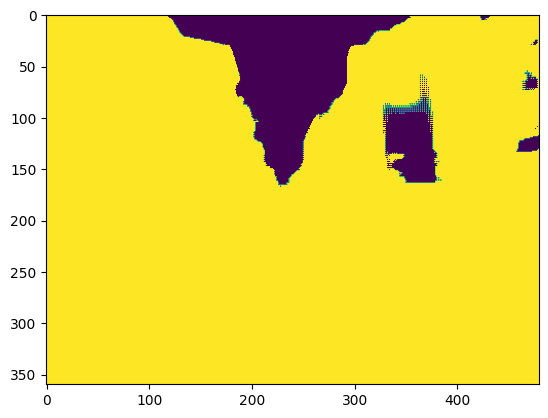

In [ ]:
predict_single_image(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used/train/images/0016E5_06330.png")

In [ ]:
#LR 0.0001 epoch 50
program_main()

293
['0001TP_006690.png', '0001TP_006720.png']
74
['0016E5_06210.png', '0016E5_06240.png']
Data Loaded Successfully!
Model successfully loaded!
Epoch: 20
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.7335160970687866
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  7.12it/s]


Loss Validation : 0.7214994430541992
Epoch completed and model successfully saved!
Epoch: 21
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.466064453125
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


Loss Validation : 0.5692304372787476
Epoch completed and model successfully saved!
Epoch: 22
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.5432333946228027
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


Loss Validation : 0.6255780458450317
Epoch completed and model successfully saved!
Epoch: 23
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.536277174949646
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


Loss Validation : 0.6650028228759766
Epoch completed and model successfully saved!
Epoch: 24
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.46it/s]


Loss Train : 0.4993184804916382
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


Loss Validation : 0.6468923091888428
Epoch completed and model successfully saved!
Epoch: 25
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.5551974773406982
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.5785028338432312
Epoch completed and model successfully saved!
Epoch: 26
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.5264683961868286
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Loss Validation : 0.5532594323158264
Epoch completed and model successfully saved!
Epoch: 27
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.4482177495956421
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.5482041835784912
Epoch completed and model successfully saved!
Epoch: 28
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.5142428874969482
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.6238691806793213
Epoch completed and model successfully saved!
Epoch: 29
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.6132144927978516
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Loss Validation : 0.6489226222038269
Epoch completed and model successfully saved!
Epoch: 30
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.5165736675262451
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.5654449462890625
Epoch completed and model successfully saved!
Epoch: 31
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.43341249227523804
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.5213306546211243
Epoch completed and model successfully saved!
Epoch: 32
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.20it/s]


Loss Train : 0.44392818212509155
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Loss Validation : 0.5798892974853516
Epoch completed and model successfully saved!
Epoch: 33
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.48248589038848877
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


Loss Validation : 0.558262825012207
Epoch completed and model successfully saved!
Epoch: 34
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.49314993619918823
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.5604522228240967
Epoch completed and model successfully saved!
Epoch: 35
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.5095027685165405
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.5748001337051392
Epoch completed and model successfully saved!
Epoch: 36
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.5214535593986511
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


Loss Validation : 0.5227552652359009
Epoch completed and model successfully saved!
Epoch: 37
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.462649405002594
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.5798145532608032
Epoch completed and model successfully saved!
Epoch: 38
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.44195759296417236
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.5762499570846558
Epoch completed and model successfully saved!
Epoch: 39
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.492206335067749
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


Loss Validation : 0.572753369808197
Epoch completed and model successfully saved!
Epoch: 40
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.46951329708099365
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.5897552371025085
Epoch completed and model successfully saved!
Epoch: 41
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.45805805921554565
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.577574610710144
Epoch completed and model successfully saved!
Epoch: 42
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.4448304772377014
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


Loss Validation : 0.5524998307228088
Epoch completed and model successfully saved!
Epoch: 43
Entering into train function


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


Loss Train : 0.4714951515197754
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.5398550033569336
Epoch completed and model successfully saved!
Epoch: 44
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.5060965418815613
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Loss Validation : 0.48496031761169434
Epoch completed and model successfully saved!
Epoch: 45
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.530458390712738
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.5941295623779297
Epoch completed and model successfully saved!
Epoch: 46
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


Loss Train : 0.5032261610031128
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.49866795539855957
Epoch completed and model successfully saved!
Epoch: 47
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.4595707654953003
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.5608590841293335
Epoch completed and model successfully saved!
Epoch: 48
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.47556644678115845
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.6297132968902588
Epoch completed and model successfully saved!
Epoch: 49
Entering into train function


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


Loss Train : 0.4458070397377014
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.5398917198181152
Epoch completed and model successfully saved!


Running on the GPU


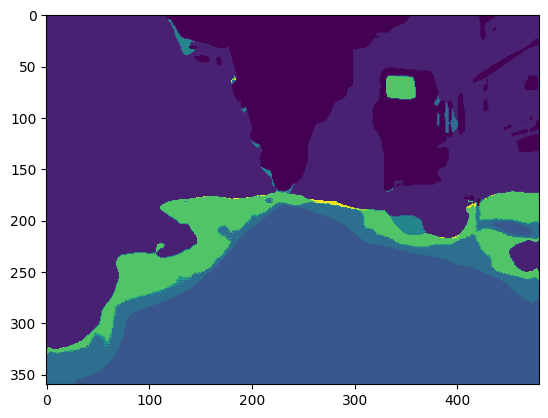

In [ ]:
predict_single_image(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used/train/images/0016E5_06330.png")

In [ ]:
#LR 0.0001 epoch 100
program_main()

293
['0001TP_006690.png', '0001TP_006720.png']
74
['0016E5_06210.png', '0016E5_06240.png']
Data Loaded Successfully!
Model successfully loaded!
Epoch: 50
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.6456012725830078
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


Loss Validation : 0.6184365749359131
Epoch completed and model successfully saved!
Epoch: 51
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.5183402299880981
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


Loss Validation : 0.5207133293151855
Epoch completed and model successfully saved!
Epoch: 52
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.4627463221549988
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


Loss Validation : 0.5345919728279114
Epoch completed and model successfully saved!
Epoch: 53
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.44it/s]


Loss Train : 0.43544304370880127
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


Loss Validation : 0.48066437244415283
Epoch completed and model successfully saved!
Epoch: 54
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.46453481912612915
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


Loss Validation : 0.5316861867904663
Epoch completed and model successfully saved!
Epoch: 55
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.4040030241012573
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Loss Validation : 0.530880868434906
Epoch completed and model successfully saved!
Epoch: 56
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.4319693446159363
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Loss Validation : 0.5940276384353638
Epoch completed and model successfully saved!
Epoch: 57
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.44689077138900757
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Loss Validation : 0.561683714389801
Epoch completed and model successfully saved!
Epoch: 58
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.4433101415634155
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.5581167340278625
Epoch completed and model successfully saved!
Epoch: 59
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.3986924886703491
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Loss Validation : 0.542511522769928
Epoch completed and model successfully saved!
Epoch: 60
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.4274253249168396
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.4733247756958008
Epoch completed and model successfully saved!
Epoch: 61
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.38314008712768555
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


Loss Validation : 0.5692436099052429
Epoch completed and model successfully saved!
Epoch: 62
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.4169923663139343
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.6180062294006348
Epoch completed and model successfully saved!
Epoch: 63
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.4437274932861328
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.5896338224411011
Epoch completed and model successfully saved!
Epoch: 64
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.4501070976257324
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.40841686725616455
Epoch completed and model successfully saved!
Epoch: 65
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


Loss Train : 0.37169724702835083
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.5931291580200195
Epoch completed and model successfully saved!
Epoch: 66
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.4205894470214844
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


Loss Validation : 0.5517945885658264
Epoch completed and model successfully saved!
Epoch: 67
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.36046844720840454
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


Loss Validation : 0.5405324101448059
Epoch completed and model successfully saved!
Epoch: 68
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.49767380952835083
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.5164437890052795
Epoch completed and model successfully saved!
Epoch: 69
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.4049614667892456
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.6098204851150513
Epoch completed and model successfully saved!
Epoch: 70
Entering into train function


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


Loss Train : 0.3247734308242798
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.5736685395240784
Epoch completed and model successfully saved!
Epoch: 71
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.461350679397583
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


Loss Validation : 0.5200787782669067
Epoch completed and model successfully saved!
Epoch: 72
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.41598325967788696
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Loss Validation : 0.4774845242500305
Epoch completed and model successfully saved!
Epoch: 73
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.46741950511932373
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.5028240084648132
Epoch completed and model successfully saved!
Epoch: 74
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.4612833261489868
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.5733620524406433
Epoch completed and model successfully saved!
Epoch: 75
Entering into train function


100%|██████████| 37/37 [00:17<00:00,  2.16it/s]


Loss Train : 0.4254074692726135
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.614372193813324
Epoch completed and model successfully saved!
Epoch: 76
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.453909695148468
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


Loss Validation : 0.5747861266136169
Epoch completed and model successfully saved!
Epoch: 77
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.40592002868652344
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.5458133220672607
Epoch completed and model successfully saved!
Epoch: 78
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.47409284114837646
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.48156440258026123
Epoch completed and model successfully saved!
Epoch: 79
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.44411468505859375
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.5357080698013306
Epoch completed and model successfully saved!
Epoch: 80
Entering into train function


100%|██████████| 37/37 [00:17<00:00,  2.16it/s]


Loss Train : 0.40876179933547974
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.5821239948272705
Epoch completed and model successfully saved!
Epoch: 81
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.4630456566810608
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


Loss Validation : 0.6229304075241089
Epoch completed and model successfully saved!
Epoch: 82
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.5084673166275024
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.5873010754585266
Epoch completed and model successfully saved!
Epoch: 83
Entering into train function


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


Loss Train : 0.4164367914199829
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.5953247547149658
Epoch completed and model successfully saved!
Epoch: 84
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.3611324429512024
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


Loss Validation : 0.5380398035049438
Epoch completed and model successfully saved!
Epoch: 85
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.46160781383514404
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


Loss Validation : 0.5459483861923218
Epoch completed and model successfully saved!
Epoch: 86
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.4224591851234436
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.5568364858627319
Epoch completed and model successfully saved!
Epoch: 87
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.4122768044471741
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.550200343132019
Epoch completed and model successfully saved!
Epoch: 88
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


Loss Train : 0.3921055793762207
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Loss Validation : 0.4540151357650757
Epoch completed and model successfully saved!
Epoch: 89
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.35678577423095703
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Loss Validation : 0.5595303177833557
Epoch completed and model successfully saved!
Epoch: 90
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.4782150387763977
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Loss Validation : 0.6254907846450806
Epoch completed and model successfully saved!
Epoch: 91
Entering into train function


100%|██████████| 37/37 [00:17<00:00,  2.08it/s]


Loss Train : 0.39288634061813354
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


Loss Validation : 0.5155776739120483
Epoch completed and model successfully saved!
Epoch: 92
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.3313267230987549
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


Loss Validation : 0.5329673290252686
Epoch completed and model successfully saved!
Epoch: 93
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.3731430172920227
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.5084340572357178
Epoch completed and model successfully saved!
Epoch: 94
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.4259676933288574
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.5273613929748535
Epoch completed and model successfully saved!
Epoch: 95
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.4017183780670166
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.6310201287269592
Epoch completed and model successfully saved!
Epoch: 96
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.44939976930618286
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


Loss Validation : 0.5141719579696655
Epoch completed and model successfully saved!
Epoch: 97
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.5247688293457031
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.544231653213501
Epoch completed and model successfully saved!
Epoch: 98
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.40325599908828735
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.527000904083252
Epoch completed and model successfully saved!
Epoch: 99
Entering into train function


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


Loss Train : 0.45164161920547485
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


Loss Validation : 0.627291202545166
Epoch completed and model successfully saved!


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


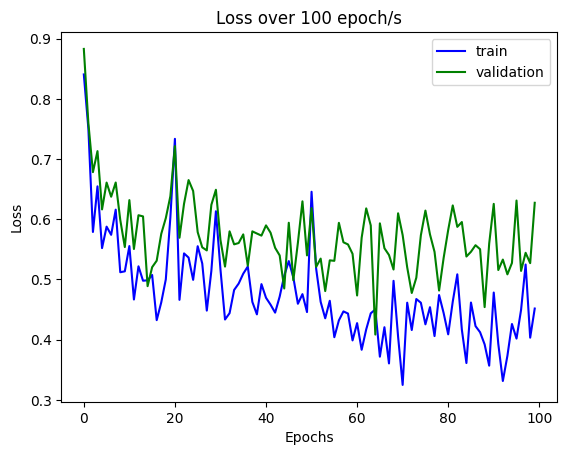

In [ ]:
plot_losses(MODEL_PATH)

Running on the GPU


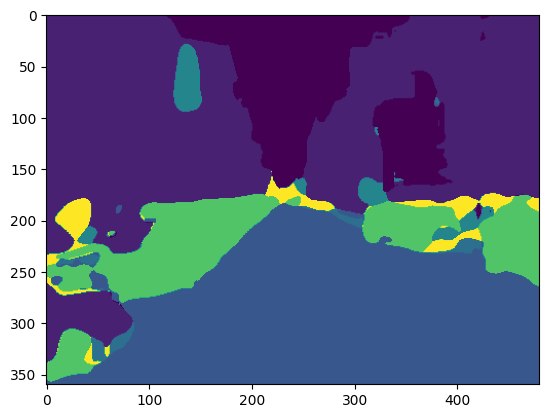

In [ ]:
predict_single_image(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used/train/images/0016E5_06330.png")

In [ ]:
#LR 0.0005 epoch 80
program_main()

293
['0001TP_006690.png', '0001TP_006720.png']
74
['0016E5_06210.png', '0016E5_06240.png']
Data Loaded Successfully!
Epoch: 0
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.7474565505981445
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Loss Validation : 0.9077144861221313
Epoch completed and model successfully saved!
Epoch: 1
Entering into train function


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


Loss Train : 0.763313889503479
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Loss Validation : 0.7617448568344116
Epoch completed and model successfully saved!
Epoch: 2
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.6929653882980347
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


Loss Validation : 0.73993319272995
Epoch completed and model successfully saved!
Epoch: 3
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.7040082216262817
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.8252571821212769
Epoch completed and model successfully saved!
Epoch: 4
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.7617998123168945
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.8173456788063049
Epoch completed and model successfully saved!
Epoch: 5
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.6997058391571045
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Loss Validation : 0.773733377456665
Epoch completed and model successfully saved!
Epoch: 6
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.7018517851829529
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.7587874531745911
Epoch completed and model successfully saved!
Epoch: 7
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.6801701784133911
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Loss Validation : 0.6776604056358337
Epoch completed and model successfully saved!
Epoch: 8
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.7839093208312988
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.7946208715438843
Epoch completed and model successfully saved!
Epoch: 9
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.7476277351379395
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Loss Validation : 0.8244985342025757
Epoch completed and model successfully saved!
Epoch: 10
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.757552444934845
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.8446564078330994
Epoch completed and model successfully saved!
Epoch: 11
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Loss Train : 0.7529510855674744
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.810582160949707
Epoch completed and model successfully saved!
Epoch: 12
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.6587382555007935
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


Loss Validation : 0.7515519857406616
Epoch completed and model successfully saved!
Epoch: 13
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.7347001433372498
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Loss Validation : 0.7937355041503906
Epoch completed and model successfully saved!
Epoch: 14
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.6833087205886841
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.7096666097640991
Epoch completed and model successfully saved!
Epoch: 15
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.7254260182380676
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.7865037322044373
Epoch completed and model successfully saved!
Epoch: 16
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.6778824329376221
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.7399026155471802
Epoch completed and model successfully saved!
Epoch: 17
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.7959234118461609
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Loss Validation : 0.8157570362091064
Epoch completed and model successfully saved!
Epoch: 18
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.7125301361083984
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Loss Validation : 0.7639083862304688
Epoch completed and model successfully saved!
Epoch: 19
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.6958026885986328
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.7433357834815979
Epoch completed and model successfully saved!
Epoch: 20
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.6600720286369324
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.8274983167648315
Epoch completed and model successfully saved!
Epoch: 21
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.7087575793266296
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.8023077249526978
Epoch completed and model successfully saved!
Epoch: 22
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.7710025310516357
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


Loss Validation : 0.769649863243103
Epoch completed and model successfully saved!
Epoch: 23
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.6847033500671387
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.7407731413841248
Epoch completed and model successfully saved!
Epoch: 24
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.6586100459098816
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.8164271116256714
Epoch completed and model successfully saved!
Epoch: 25
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.6302790641784668
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.8260730504989624
Epoch completed and model successfully saved!
Epoch: 26
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.6999557018280029
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Loss Validation : 0.8374581336975098
Epoch completed and model successfully saved!
Epoch: 27
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.7789525985717773
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.8033181428909302
Epoch completed and model successfully saved!
Epoch: 28
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.7237344980239868
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Loss Validation : 0.7081542611122131
Epoch completed and model successfully saved!
Epoch: 29
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.7138301134109497
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.7979641556739807
Epoch completed and model successfully saved!
Epoch: 30
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.6952252984046936
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.7223401069641113
Epoch completed and model successfully saved!
Epoch: 31
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.6972399950027466
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Loss Validation : 0.784677267074585
Epoch completed and model successfully saved!
Epoch: 32
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.7259083390235901
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.8395085334777832
Epoch completed and model successfully saved!
Epoch: 33
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.6744851469993591
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.7112583518028259
Epoch completed and model successfully saved!
Epoch: 34
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.6601150035858154
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.8427281379699707
Epoch completed and model successfully saved!
Epoch: 35
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.7035540342330933
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Loss Validation : 0.8299100399017334
Epoch completed and model successfully saved!
Epoch: 36
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.7505285739898682
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.7530020475387573
Epoch completed and model successfully saved!
Epoch: 37
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.6196443438529968
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Loss Validation : 0.7858608365058899
Epoch completed and model successfully saved!
Epoch: 38
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.659950852394104
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.7479557991027832
Epoch completed and model successfully saved!
Epoch: 39
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.7394504547119141
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.8245096206665039
Epoch completed and model successfully saved!
Epoch: 40
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.7337214946746826
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Loss Validation : 0.7603439092636108
Epoch completed and model successfully saved!
Epoch: 41
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.7262217402458191
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Loss Validation : 0.8114181160926819
Epoch completed and model successfully saved!
Epoch: 42
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.6633543372154236
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.8268986344337463
Epoch completed and model successfully saved!
Epoch: 43
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.6692601442337036
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.7939107418060303
Epoch completed and model successfully saved!
Epoch: 44
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.6898878812789917
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.815222442150116
Epoch completed and model successfully saved!
Epoch: 45
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.6953636407852173
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.7959703803062439
Epoch completed and model successfully saved!
Epoch: 46
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.6604871153831482
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.8119142055511475
Epoch completed and model successfully saved!
Epoch: 47
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.7085368633270264
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.792527973651886
Epoch completed and model successfully saved!
Epoch: 48
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.7216562032699585
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Loss Validation : 0.7508227825164795
Epoch completed and model successfully saved!
Epoch: 49
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.6588881015777588
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.7456590533256531
Epoch completed and model successfully saved!
Epoch: 50
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.723522424697876
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.7867020964622498
Epoch completed and model successfully saved!
Epoch: 51
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.701650857925415
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.8352842330932617
Epoch completed and model successfully saved!
Epoch: 52
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.7452436685562134
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.7122623324394226
Epoch completed and model successfully saved!
Epoch: 53
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.7378785610198975
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Loss Validation : 0.7811123132705688
Epoch completed and model successfully saved!
Epoch: 54
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.6760968565940857
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.820891797542572
Epoch completed and model successfully saved!
Epoch: 55
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.6493803262710571
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Loss Validation : 0.8180809020996094
Epoch completed and model successfully saved!
Epoch: 56
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.6782600283622742
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.8168139457702637
Epoch completed and model successfully saved!
Epoch: 57
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.6612199544906616
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Loss Validation : 0.63663250207901
Epoch completed and model successfully saved!
Epoch: 58
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.5918828248977661
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Loss Validation : 0.7384846210479736
Epoch completed and model successfully saved!
Epoch: 59
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.6521257162094116
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Loss Validation : 0.73567795753479
Epoch completed and model successfully saved!
Epoch: 60
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.6158585548400879
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Loss Validation : 0.7365433573722839
Epoch completed and model successfully saved!
Epoch: 61
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Loss Train : 0.6793508529663086
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Loss Validation : 0.739757776260376
Epoch completed and model successfully saved!
Epoch: 62
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.7829083800315857
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.8162528276443481
Epoch completed and model successfully saved!
Epoch: 63
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.48it/s]


Loss Train : 0.8708518147468567
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.9841961860656738
Epoch completed and model successfully saved!
Epoch: 64
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.8535730838775635
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Loss Validation : 0.9018626809120178
Epoch completed and model successfully saved!
Epoch: 65
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.8514317870140076
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.859409511089325
Epoch completed and model successfully saved!
Epoch: 66
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.836326539516449
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Loss Validation : 0.7355060577392578
Epoch completed and model successfully saved!
Epoch: 67
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.7890701293945312
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Loss Validation : 0.9810507893562317
Epoch completed and model successfully saved!
Epoch: 68
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Loss Train : 0.8964115977287292
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Loss Validation : 0.89708411693573
Epoch completed and model successfully saved!
Epoch: 69
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.8716183304786682
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Loss Validation : 0.9826099872589111
Epoch completed and model successfully saved!
Epoch: 70
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.44it/s]


Loss Train : 0.8589386940002441
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


Loss Validation : 0.8553898334503174
Epoch completed and model successfully saved!
Epoch: 71
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.50it/s]


Loss Train : 0.837456226348877
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Loss Validation : 0.8619881868362427
Epoch completed and model successfully saved!
Epoch: 72
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


Loss Train : 0.801488995552063
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Loss Validation : 0.8588272929191589
Epoch completed and model successfully saved!
Epoch: 73
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Loss Train : 0.8409457802772522
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Loss Validation : 0.9027861952781677
Epoch completed and model successfully saved!
Epoch: 74
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Loss Train : 0.8706800937652588
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Loss Validation : 0.939235508441925
Epoch completed and model successfully saved!
Epoch: 75
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.46it/s]


Loss Train : 0.8578260540962219
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.9370761513710022
Epoch completed and model successfully saved!
Epoch: 76
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.45it/s]


Loss Train : 0.8900217413902283
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Loss Validation : 0.9019970297813416
Epoch completed and model successfully saved!
Epoch: 77
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.7937538027763367
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Loss Validation : 0.9009485244750977
Epoch completed and model successfully saved!
Epoch: 78
Entering into train function


100%|██████████| 37/37 [00:14<00:00,  2.50it/s]


Loss Train : 0.8415740728378296
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.8555126190185547
Epoch completed and model successfully saved!
Epoch: 79
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.43it/s]


Loss Train : 0.833499014377594
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Loss Validation : 0.9418244361877441
Epoch completed and model successfully saved!


Running on the GPU


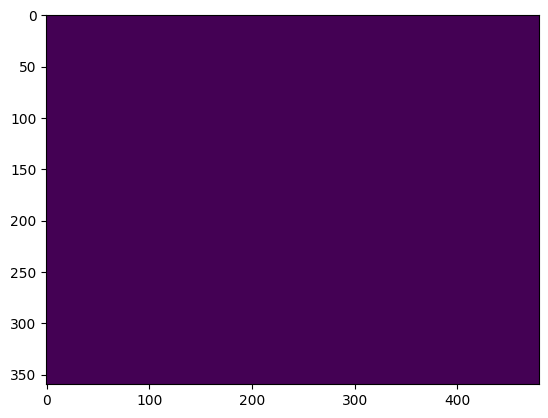

In [ ]:
predict_single_image(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used/train/images/0016E5_06330.png")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


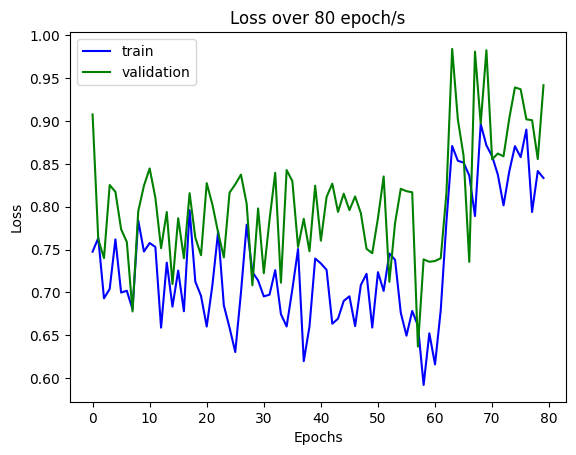

In [ ]:
plot_losses(MODEL_PATH)

In [ ]:
#LR 0.0002 epoch 80
program_main()

293
['0001TP_006690.png', '0001TP_006720.png']
74
['0016E5_06210.png', '0016E5_06240.png']
Data Loaded Successfully!
Epoch: 0
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.8019991517066956
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


Loss Validation : 0.8672515153884888
Epoch completed and model successfully saved!
Epoch: 1
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.7302757501602173
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Loss Validation : 0.7696262001991272
Epoch completed and model successfully saved!
Epoch: 2
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.679131269454956
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.7323992252349854
Epoch completed and model successfully saved!
Epoch: 3
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.7214680910110474
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.7607988715171814
Epoch completed and model successfully saved!
Epoch: 4
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.6683698892593384
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.7811511754989624
Epoch completed and model successfully saved!
Epoch: 5
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.6768481731414795
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.7097852230072021
Epoch completed and model successfully saved!
Epoch: 6
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.22it/s]


Loss Train : 0.6158227920532227
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.8057181239128113
Epoch completed and model successfully saved!
Epoch: 7
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.6823439598083496
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


Loss Validation : 0.6773899793624878
Epoch completed and model successfully saved!
Epoch: 8
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.7455708980560303
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.7634603977203369
Epoch completed and model successfully saved!
Epoch: 9
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.6890714168548584
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.8158882260322571
Epoch completed and model successfully saved!
Epoch: 10
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.738937497138977
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.82941734790802
Epoch completed and model successfully saved!
Epoch: 11
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.5894162058830261
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.8231950402259827
Epoch completed and model successfully saved!
Epoch: 12
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.7122827768325806
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


Loss Validation : 0.7903405427932739
Epoch completed and model successfully saved!
Epoch: 13
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.20it/s]


Loss Train : 0.7285206317901611
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.7873735427856445
Epoch completed and model successfully saved!
Epoch: 14
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.7290815114974976
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Loss Validation : 0.7191145420074463
Epoch completed and model successfully saved!
Epoch: 15
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.6571387052536011
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.8365309834480286
Epoch completed and model successfully saved!
Epoch: 16
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.19it/s]


Loss Train : 0.662216305732727
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.7538849711418152
Epoch completed and model successfully saved!
Epoch: 17
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.7161805629730225
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.7902750372886658
Epoch completed and model successfully saved!
Epoch: 18
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


Loss Train : 0.6632390022277832
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.8156798481941223
Epoch completed and model successfully saved!
Epoch: 19
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.7464670538902283
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


Loss Validation : 0.7846126556396484
Epoch completed and model successfully saved!
Epoch: 20
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.631218433380127
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.7193894982337952
Epoch completed and model successfully saved!
Epoch: 21
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.7773450016975403
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.6994845271110535
Epoch completed and model successfully saved!
Epoch: 22
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


Loss Train : 0.7411373853683472
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.8046581149101257
Epoch completed and model successfully saved!
Epoch: 23
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


Loss Train : 0.7612344026565552
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.7848087549209595
Epoch completed and model successfully saved!
Epoch: 24
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.7078417539596558
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


Loss Validation : 0.7791229486465454
Epoch completed and model successfully saved!
Epoch: 25
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Loss Train : 0.6179456114768982
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.8236551880836487
Epoch completed and model successfully saved!
Epoch: 26
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.7941274642944336
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.9044027924537659
Epoch completed and model successfully saved!
Epoch: 27
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Loss Train : 0.7063233852386475
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Loss Validation : 0.8368784189224243
Epoch completed and model successfully saved!
Epoch: 28
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.6384657621383667
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.7572568655014038
Epoch completed and model successfully saved!
Epoch: 29
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.6692034006118774
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.8305841088294983
Epoch completed and model successfully saved!
Epoch: 30
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.756144106388092
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.8271262049674988
Epoch completed and model successfully saved!
Epoch: 31
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.7131918668746948
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Loss Validation : 0.7343018651008606
Epoch completed and model successfully saved!
Epoch: 32
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Loss Train : 0.7366653084754944
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Loss Validation : 0.7982749342918396
Epoch completed and model successfully saved!
Epoch: 33
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.6863682270050049
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.8146573305130005
Epoch completed and model successfully saved!
Epoch: 34
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.6378904581069946
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.6805772185325623
Epoch completed and model successfully saved!
Epoch: 35
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.74467933177948
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.7831028699874878
Epoch completed and model successfully saved!
Epoch: 36
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.21it/s]


Loss Train : 0.7233191728591919
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.8231453895568848
Epoch completed and model successfully saved!
Epoch: 37
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.5869381427764893
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.7716189026832581
Epoch completed and model successfully saved!
Epoch: 38
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.7221444845199585
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Loss Validation : 0.8427101969718933
Epoch completed and model successfully saved!
Epoch: 39
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.690565824508667
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


Loss Validation : 0.8211082816123962
Epoch completed and model successfully saved!
Epoch: 40
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.7445756196975708
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Loss Validation : 0.7102749943733215
Epoch completed and model successfully saved!
Epoch: 41
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.646996259689331
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.8187340497970581
Epoch completed and model successfully saved!
Epoch: 42
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.7019892930984497
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.8040555715560913
Epoch completed and model successfully saved!
Epoch: 43
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Loss Train : 0.6656900644302368
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.8425708413124084
Epoch completed and model successfully saved!
Epoch: 44
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.7326155304908752
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


Loss Validation : 0.752106249332428
Epoch completed and model successfully saved!
Epoch: 45
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Loss Train : 0.738597571849823
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.8177642226219177
Epoch completed and model successfully saved!
Epoch: 46
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.6784877181053162
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.7793051600456238
Epoch completed and model successfully saved!
Epoch: 47
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.7039411067962646
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Loss Validation : 0.7365977764129639
Epoch completed and model successfully saved!
Epoch: 48
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.7057783007621765
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.7497540712356567
Epoch completed and model successfully saved!
Epoch: 49
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.6154934167861938
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


Loss Validation : 0.7437888979911804
Epoch completed and model successfully saved!
Epoch: 50
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Loss Train : 0.6588075160980225
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Loss Validation : 0.753122866153717
Epoch completed and model successfully saved!
Epoch: 51
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.655398964881897
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.8104526400566101
Epoch completed and model successfully saved!
Epoch: 52
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.7435574531555176
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Loss Validation : 0.7837127447128296
Epoch completed and model successfully saved!
Epoch: 53
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


Loss Train : 0.6797653436660767
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.8166216611862183
Epoch completed and model successfully saved!
Epoch: 54
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.7273799180984497
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


Loss Validation : 0.8016175031661987
Epoch completed and model successfully saved!
Epoch: 55
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.6560660600662231
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Loss Validation : 0.8004553318023682
Epoch completed and model successfully saved!
Epoch: 56
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.6640045642852783
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.7647408246994019
Epoch completed and model successfully saved!
Epoch: 57
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Loss Train : 0.6231405735015869
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.7365365624427795
Epoch completed and model successfully saved!
Epoch: 58
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.19it/s]


Loss Train : 0.7129768133163452
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.8211421966552734
Epoch completed and model successfully saved!
Epoch: 59
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.6698593497276306
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Loss Validation : 0.8280498385429382
Epoch completed and model successfully saved!
Epoch: 60
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


Loss Train : 0.6768308877944946
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Loss Validation : 0.720960259437561
Epoch completed and model successfully saved!
Epoch: 61
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


Loss Train : 0.6696807146072388
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Loss Validation : 0.7375275492668152
Epoch completed and model successfully saved!
Epoch: 62
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.6962029933929443
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.7103860378265381
Epoch completed and model successfully saved!
Epoch: 63
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


Loss Train : 0.6661279201507568
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.8166334629058838
Epoch completed and model successfully saved!
Epoch: 64
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.6753671169281006
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Loss Validation : 0.8174917697906494
Epoch completed and model successfully saved!
Epoch: 65
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Loss Train : 0.7399564981460571
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Loss Validation : 0.751442551612854
Epoch completed and model successfully saved!
Epoch: 66
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.6254223585128784
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.7073778510093689
Epoch completed and model successfully saved!
Epoch: 67
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.31it/s]


Loss Train : 0.6561895608901978
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.7476972341537476
Epoch completed and model successfully saved!
Epoch: 68
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.19it/s]


Loss Train : 0.6644914150238037
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Loss Validation : 0.7779770493507385
Epoch completed and model successfully saved!
Epoch: 69
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.5238332748413086
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Loss Validation : 0.6925379633903503
Epoch completed and model successfully saved!
Epoch: 70
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.19it/s]


Loss Train : 0.5928000211715698
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Loss Validation : 0.709459662437439
Epoch completed and model successfully saved!
Epoch: 71
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.6109662055969238
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


Loss Validation : 0.7946470379829407
Epoch completed and model successfully saved!
Epoch: 72
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Loss Train : 0.689856767654419
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.8189559578895569
Epoch completed and model successfully saved!
Epoch: 73
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.5381657481193542
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Loss Validation : 0.8356481790542603
Epoch completed and model successfully saved!
Epoch: 74
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


Loss Train : 0.7298399209976196
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Loss Validation : 0.7771570086479187
Epoch completed and model successfully saved!
Epoch: 75
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Loss Train : 0.6304191946983337
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Loss Validation : 0.8208047747612
Epoch completed and model successfully saved!
Epoch: 76
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.7204055786132812
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


Loss Validation : 0.8386791944503784
Epoch completed and model successfully saved!
Epoch: 77
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Loss Train : 0.7055013179779053
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Loss Validation : 0.778978168964386
Epoch completed and model successfully saved!
Epoch: 78
Entering into train function


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Loss Train : 0.5875344276428223
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Loss Validation : 0.8208785057067871
Epoch completed and model successfully saved!
Epoch: 79
Entering into train function


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Loss Train : 0.6869627237319946
Entering into validation function


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Loss Validation : 0.8230996131896973
Epoch completed and model successfully saved!


Running on the GPU


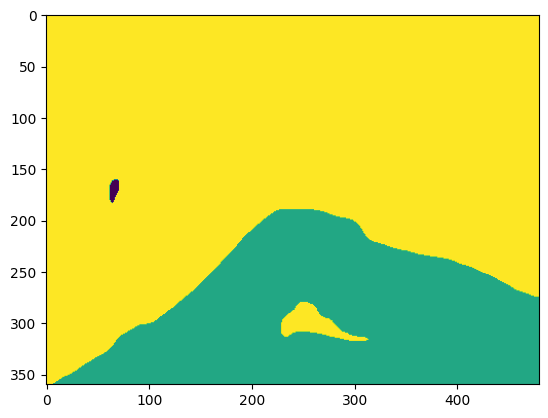

In [ ]:
predict_single_image(f"/content/drive/MyDrive/Colab Notebooks/Driving_Car/datasets_used/train/images/0016E5_06330.png")

In [ ]:
if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')
print(DEVICE)
unet = UNET(in_channels=3, classes=9).to(DEVICE).train()
unet.cuda()

Running on the GPU
cuda:0


UNET(
  (double_conv_downs): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(256, 256, kernel

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class UNET2(nn.Module):

    def __init__(self, in_channels=3, classes=1):
        super(UNET2, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []

        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

In [ ]:
model = UNET2(in_channels=3, classes=9)
model.cuda()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
